/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1g03sIzi8F855KRMi0wmJesdiVQe219nY
From (redirected): https://drive.google.com/uc?id=1g03sIzi8F855KRMi0wmJesdiVQe219nY&confirm=t&uuid=9ff3d1fb-2177-4179-be3d-4ff4aba2d09a
To: /content/amhcd-data-64.zip
100% 30.7M/30.7M [00:00<00:00, 83.6MB/s]


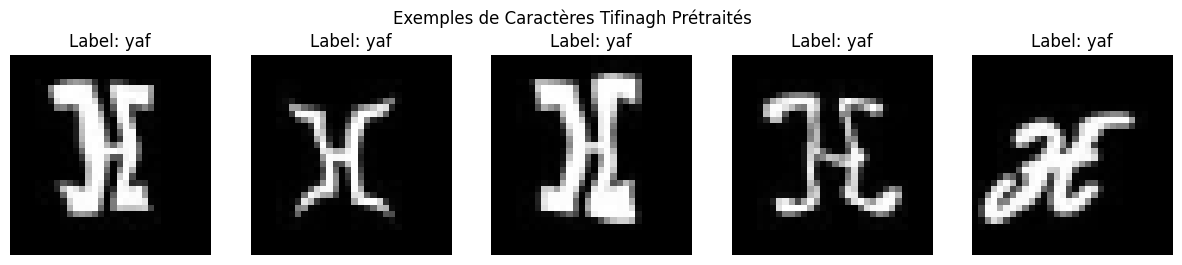

Taille du jeu d'entraînement : 16908 images
Taille du jeu de validation : 5637 images
Taille du jeu de test : 5637 images
Affichage de la distribution des classes dans chaque ensemble...


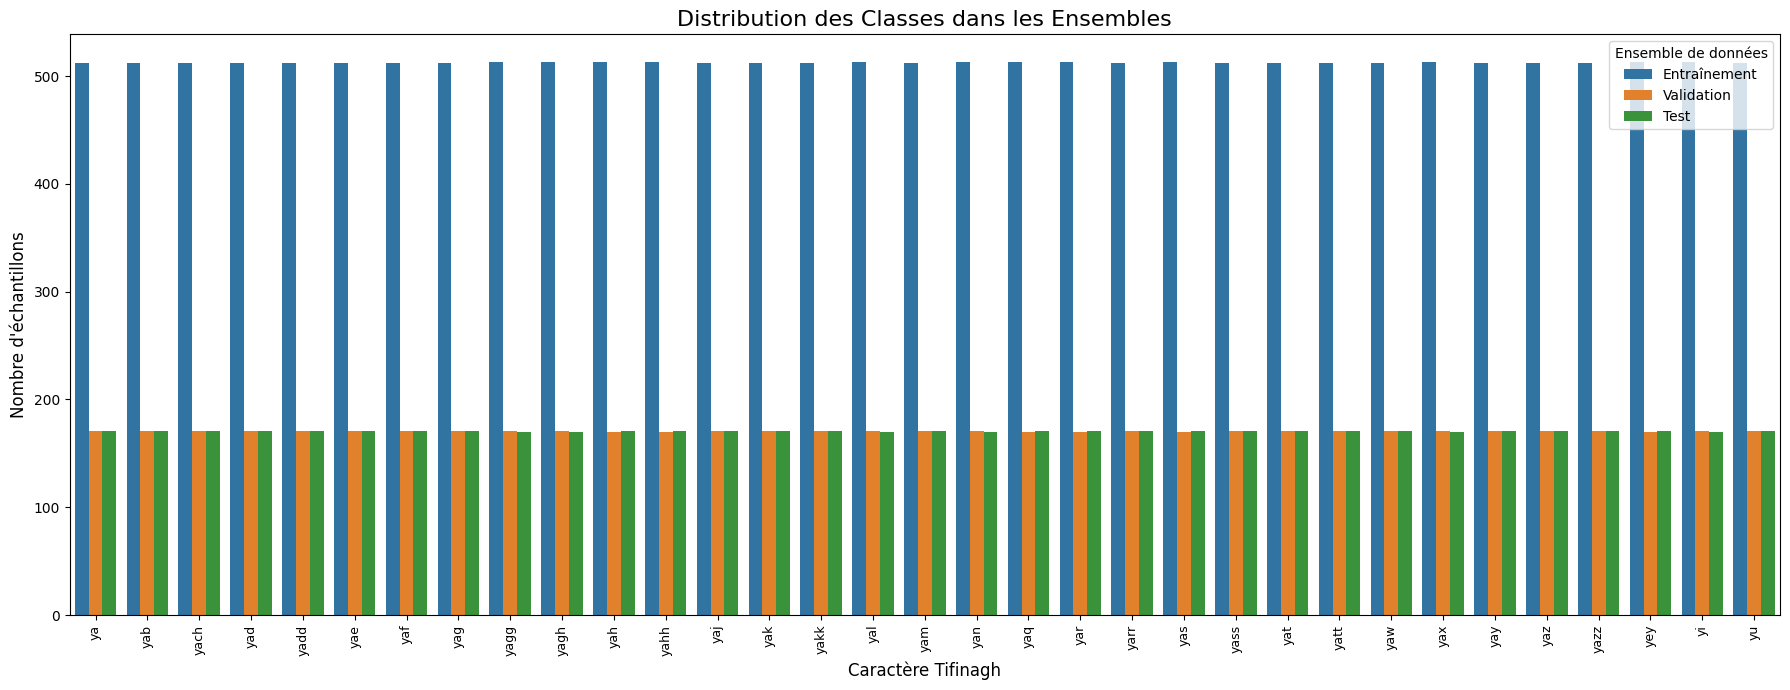

Application de l'augmentation de données...
Nouvelle taille du jeu d'entraînement après augmentation : 33816 images

Exemples d'encodage One-Hot :
Label: 'yaz' (28) -> Encodage One-Hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Label: 'yatt' (24) -> Encodage One-Hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 'yaz' (28) -> Encodage One-Hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Test avec: lr=0.001, batch_size=32, l2_lambda=0.01
Epoch 10/30 - Train Loss: 0.3434, Val Loss: 0.2230, Train Acc: 0.8994, Val Acc: 0.9313
Epoch 20/30 - Train Loss: 0.2163, Val Loss: 0.1798, Train Acc: 0.9362, Val Acc: 0.9411
Epoch 30/30 - Train Loss: 0.1660, Val Loss: 0.1656, Train Acc: 0.9494, Val Acc: 0.9478
Test avec: lr=0.001, batch_size=32, l2_lambda=0.001
Epoch 10/30 - Train Loss: 0.2680, Val Loss: 0.1881, Train Acc: 0.

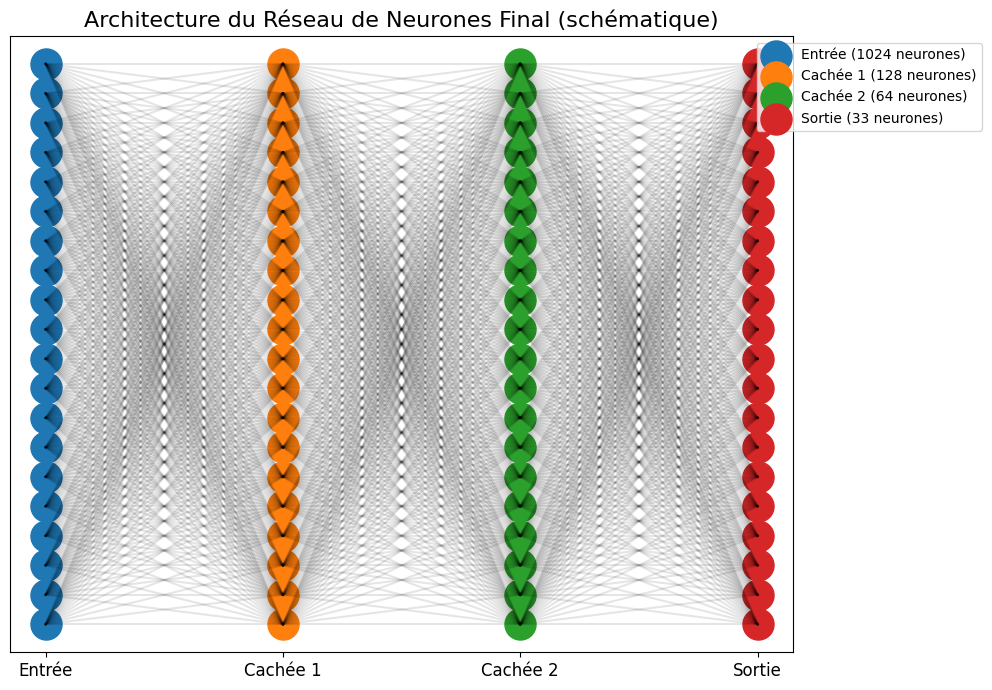

Epoch 10/100 - Train Loss: 0.3434, Val Loss: 0.2230, Train Acc: 0.8994, Val Acc: 0.9313
Epoch 20/100 - Train Loss: 0.2163, Val Loss: 0.1798, Train Acc: 0.9362, Val Acc: 0.9411
Epoch 30/100 - Train Loss: 0.1660, Val Loss: 0.1656, Train Acc: 0.9494, Val Acc: 0.9478
Epoch 40/100 - Train Loss: 0.1370, Val Loss: 0.1563, Train Acc: 0.9611, Val Acc: 0.9525
Epoch 50/100 - Train Loss: 0.1337, Val Loss: 0.1707, Train Acc: 0.9610, Val Acc: 0.9452
Epoch 60/100 - Train Loss: 0.1202, Val Loss: 0.1613, Train Acc: 0.9671, Val Acc: 0.9487
Epoch 70/100 - Train Loss: 0.1158, Val Loss: 0.1441, Train Acc: 0.9673, Val Acc: 0.9539
Epoch 80/100 - Train Loss: 0.1114, Val Loss: 0.1348, Train Acc: 0.9691, Val Acc: 0.9558
Epoch 90/100 - Train Loss: 0.1379, Val Loss: 0.1487, Train Acc: 0.9575, Val Acc: 0.9502
Epoch 100/100 - Train Loss: 0.1018, Val Loss: 0.1408, Train Acc: 0.9721, Val Acc: 0.9551

Évaluation sur le jeu de test:

Rapport de classification (Test set):
              precision    recall  f1-score   su

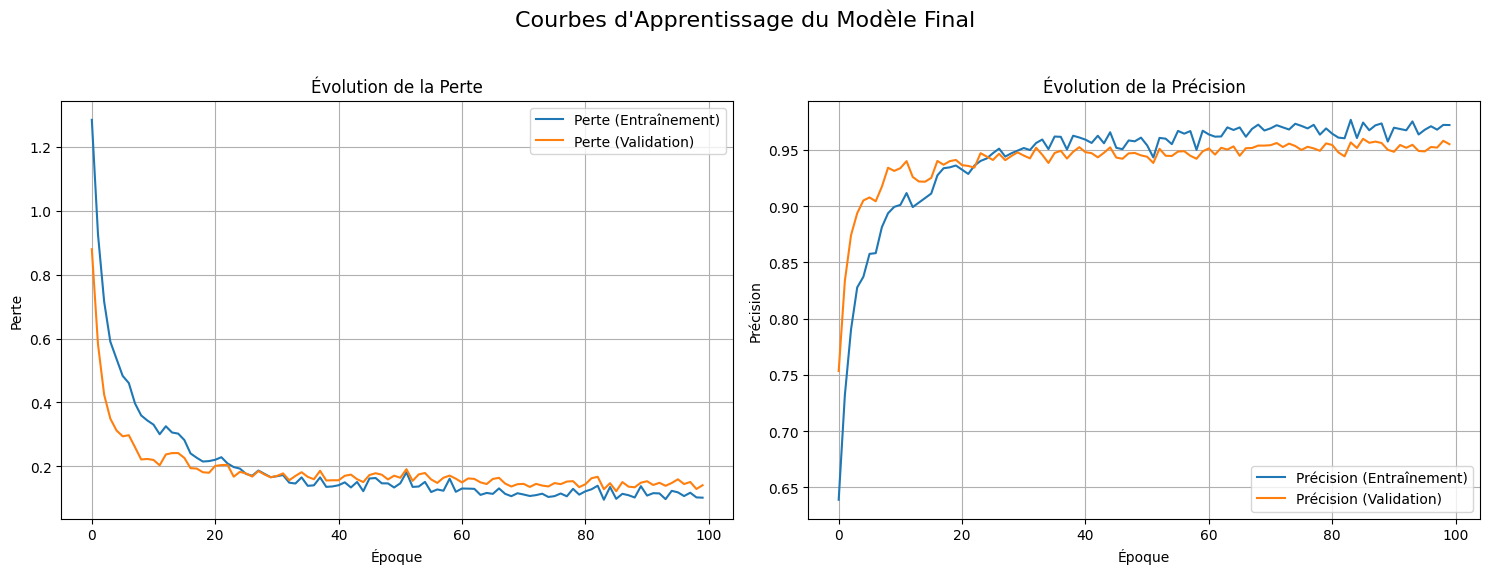

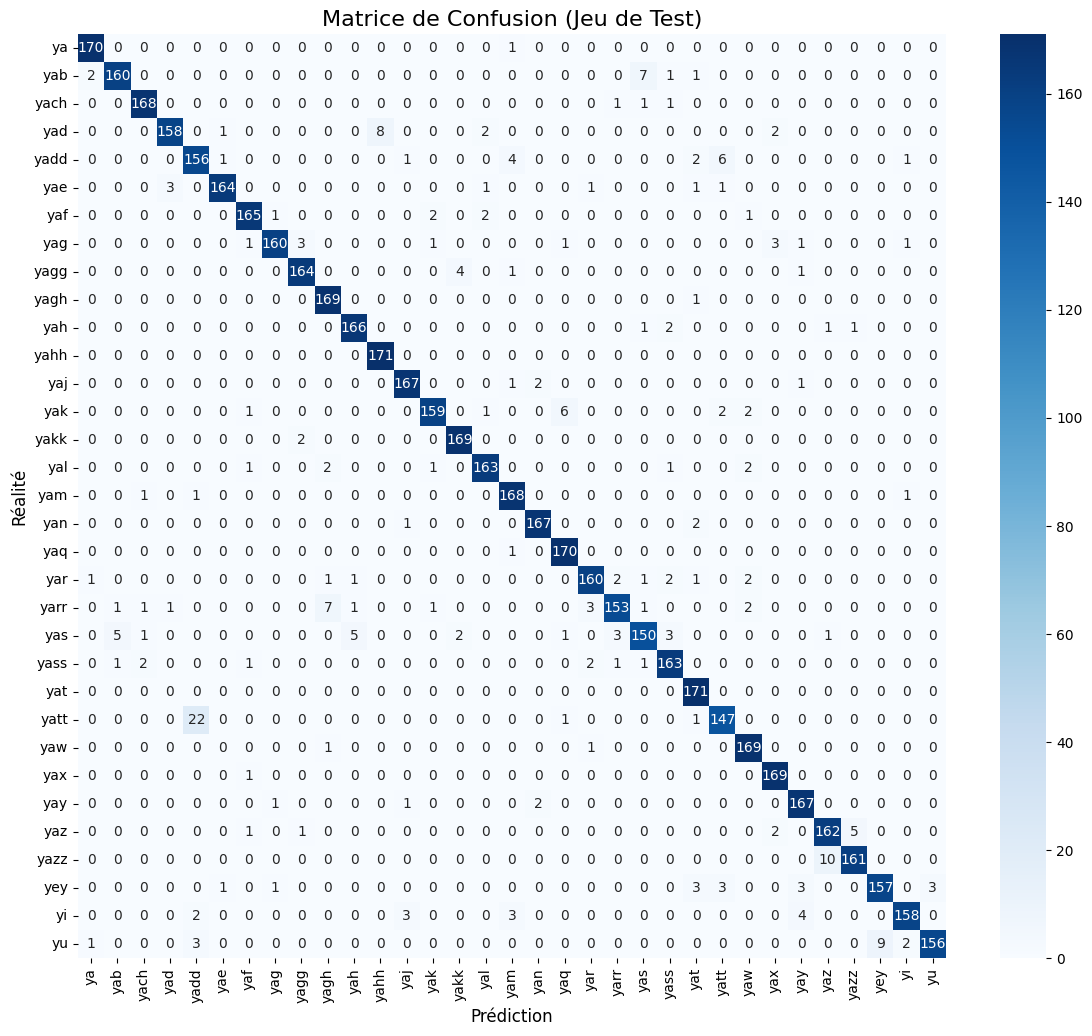

In [ ]:
!pip install -q gdown

!gdown --id 1g03sIzi8F855KRMi0wmJesdiVQe219nY -O amhcd-data-64.zip

import zipfile
with zipfile.ZipFile('amhcd-data-64.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

import os
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import time


def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

class MultiClassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.001, l2_lambda=0.01):
        assert isinstance(layer_sizes, list) and len(layer_sizes) >= 2
        assert all(isinstance(size, int) and size > 0 for size in layer_sizes)

        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda

        self.weights = []
        self.biases = []

        self.m_w, self.v_w = [], []
        self.m_b, self.v_b = [], []
        self.t = 0

        np.random.seed(42)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2. / layer_sizes[i])
            b = np.zeros((1, layer_sizes[i+1]))

            self.weights.append(w)
            self.biases.append(b)

            self.m_w.append(np.zeros_like(w))
            self.v_w.append(np.zeros_like(w))
            self.m_b.append(np.zeros_like(b))
            self.v_b.append(np.zeros_like(b))

    def forward(self, X):
        self.activations = [X]
        self.z_values = []

        for i in range(len(self.weights) - 1):
            z = self.activations[-1] @ self.weights[i] + self.biases[i]
            self.z_values.append(z)
            self.activations.append(leaky_relu(z))

        z_final = self.activations[-1] @ self.weights[-1] + self.biases[-1]
        self.z_values.append(z_final)
        output = softmax(z_final)
        self.activations.append(output)
        return output

    def compute_loss(self, y_true, y_pred):
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        core_loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        l2_penalty = 0
        for w in self.weights:
            l2_penalty += np.sum(np.square(w))
        l2_penalty *= (self.l2_lambda / (2 * y_true.shape[0]))

        return core_loss + l2_penalty

    def compute_accuracy(self, y_true, y_pred):
        predictions = np.argmax(y_pred, axis=1)
        true_labels = np.argmax(y_true, axis=1)
        return np.mean(predictions == true_labels)

    def backward(self, X, y, outputs):
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = outputs - y
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        self.d_weights[-1] += (self.l2_lambda / m) * self.weights[-1]
        for i in range(len(self.weights) - 2, -1, -1):
            dA = dZ @ self.weights[i+1].T
            dZ = dA * leaky_relu_derivative(self.z_values[i])
            self.d_weights[i] = (self.activations[i].T @ dZ) / m
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m
            self.d_weights[i] += (self.l2_lambda / m) * self.weights[i]

    def update_with_adam(self):
        self.t += 1
        beta1, beta2, epsilon = 0.9, 0.999, 1e-8

        self.m_w = [beta1 * m + (1 - beta1) * dw for m, dw in zip(self.m_w, self.d_weights)]
        self.v_w = [beta2 * v + (1 - beta2) * dw**2 for v, dw in zip(self.v_w, self.d_weights)]
        m_w_corr = [m / (1 - beta1**self.t) for m in self.m_w]
        v_w_corr = [v / (1 - beta2**self.t) for v in self.v_w]
        self.weights = [w - self.learning_rate * m / (np.sqrt(v) + epsilon) for w, m, v in zip(self.weights, m_w_corr, v_w_corr)]

        self.m_b = [beta1 * m + (1 - beta1) * db for m, db in zip(self.m_b, self.d_biases)]
        self.v_b = [beta2 * v + (1 - beta2) * db**2 for v, db in zip(self.v_b, self.d_biases)]
        m_b_corr = [m / (1 - beta1**self.t) for m in self.m_b]
        v_b_corr = [v / (1 - beta2**self.t) for v in self.v_b]
        self.biases = [b - self.learning_rate * m / (np.sqrt(v) + epsilon) for b, m, v in zip(self.biases, m_b_corr, v_b_corr)]

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

        for epoch in range(epochs):
            indices = np.random.permutation(X_train.shape[0])
            X_shuffled, y_shuffled = X_train[indices], y_train[indices]

            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                outputs = self.forward(X_batch)
                self.backward(X_batch, y_batch, outputs)
                self.update_with_adam()

            train_pred = self.forward(X_train)
            val_pred = self.forward(X_val)

            history['train_loss'].append(self.compute_loss(y_train, train_pred))
            history['val_loss'].append(self.compute_loss(y_val, val_pred))
            history['train_acc'].append(self.compute_accuracy(y_train, train_pred))
            history['val_acc'].append(self.compute_accuracy(y_val, val_pred))

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {history['train_loss'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, "
                      f"Train Acc: {history['train_acc'][-1]:.4f}, Val Acc: {history['val_acc'][-1]:.4f}")
        return history

    def predict(self, X):
        outputs = self.forward(X)
        return np.argmax(outputs, axis=1)

def load_and_preprocess_image(image_path, target_size=(32, 32)):

    if not os.path.exists(image_path):
        return None
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    img = cv2.resize(img, target_size)
    return img.astype(np.float32) / 255.0

def augment_image(image, target_size=(32, 32)):

    angle = np.random.uniform(-15, 15)
    center = (target_size[0] // 2, target_size[1] // 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, rot_mat, target_size)

    tx, ty = np.random.uniform(-3, 3, 2)
    trans_mat = np.float32([[1, 0, tx], [0, 1, ty]])
    image = cv2.warpAffine(image, trans_mat, target_size)

    return image


data_dir = os.path.join('amhcd-data-64', 'tifinagh-images')
csv_path = 'labels-map.csv'

try:
    labels_df = pd.read_csv(csv_path)
except FileNotFoundError:
    print("Fichier labels-map.csv non trouvé. Création en cours...")
    image_paths, labels = [], []
    for label_dir in os.listdir(data_dir):
        label_path = os.path.join(data_dir, label_dir)
        if os.path.isdir(label_path):
            for img_name in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, img_name))
                labels.append(label_dir)
    labels_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
    labels_df.to_csv(csv_path, index=False)

images = [load_and_preprocess_image(path) for path in labels_df['image_path']]
valid_data = [(img, lbl) for img, lbl in zip(images, labels_df['label']) if img is not None]
X_raw = np.array([data[0] for data in valid_data])
labels_raw = [data[1] for data in valid_data]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_raw)
num_classes = len(label_encoder.classes_)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X_raw[i], cmap='gray')
    original_label = label_encoder.inverse_transform([y_encoded[i]])[0]
    ax.set_title(f"Label: {original_label}")
    ax.axis('off')
plt.suptitle("Exemples de Caractères Tifinagh Prétraités")
plt.show()
X = X_raw.reshape(X_raw.shape[0], -1)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=42)

print(f"Taille du jeu d'entraînement : {X_train.shape[0]} images")
print(f"Taille du jeu de validation : {X_val.shape[0]} images")
print(f"Taille du jeu de test : {X_test.shape[0]} images")

print("Affichage de la distribution des classes dans chaque ensemble...")
splits_df = pd.DataFrame({
    'Label': label_encoder.inverse_transform(np.concatenate([y_train, y_val, y_test])),
    'Ensemble': ['Entraînement'] * len(y_train) + ['Validation'] * len(y_val) + ['Test'] * len(y_test)
})
plt.figure(figsize=(18, 7))
sns.countplot(data=splits_df, x='Label', hue='Ensemble', order=sorted(label_encoder.classes_))
plt.title("Distribution des Classes dans les Ensembles", fontsize=16)
plt.xlabel("Caractère Tifinagh", fontsize=12)
plt.ylabel("Nombre d'échantillons", fontsize=12)
plt.xticks(rotation=90, fontsize=9)
plt.legend(title="Ensemble de données")
plt.tight_layout()
plt.show()

print("Application de l'augmentation de données...")
X_train_reshaped = X_train.reshape(-1, 32, 32)
X_augmented = np.array([augment_image(img) for img in X_train_reshaped]).reshape(-1, 32*32)
X_train_full = np.vstack((X_train, X_augmented))
y_train_full = np.concatenate((y_train, y_train))
print(f"Nouvelle taille du jeu d'entraînement après augmentation : {X_train_full.shape[0]} images")

one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train_full_one_hot = one_hot_encoder.fit_transform(y_train_full.reshape(-1, 1))
y_val_one_hot = one_hot_encoder.transform(y_val.reshape(-1, 1))
y_test_one_hot = one_hot_encoder.transform(y_test.reshape(-1, 1))

print("\nExemples d'encodage One-Hot :")
for i in range(3):
    original_label = label_encoder.inverse_transform([y_train_full[i]])[0]
    print(f"Label: '{original_label}' ({y_train_full[i]}) -> Encodage One-Hot: {y_train_full_one_hot[i]}")


learning_rates = [0.001, 0.0005]
batch_sizes = [32, 64]
l2_lambdas = [0.01, 0.001]

best_params = {}
best_val_accuracy = -1
start_time = time.time()

for lr in learning_rates:
    for bs in batch_sizes:
        for l2 in l2_lambdas:
            print(f"Test avec: lr={lr}, batch_size={bs}, l2_lambda={l2}")
            nn_search = MultiClassNeuralNetwork(
                layer_sizes=[X_train_full.shape[1], 128, 64, num_classes],
                learning_rate=lr,
                l2_lambda=l2
            )
            history_search = nn_search.train(X_train_full, y_train_full_one_hot, X_val, y_val_one_hot, epochs=30, batch_size=bs)

            current_accuracy = history_search['val_acc'][-1]
            if current_accuracy > best_val_accuracy:
                best_val_accuracy = current_accuracy
                best_params = {'lr': lr, 'batch_size': bs, 'l2': l2}

print(f"\nRecherche terminée en {time.time() - start_time:.2f} secondes.")
print(f"Meilleure précision de validation trouvée: {best_val_accuracy:.4f}")
print(f"Meilleurs hyperparamètres: {best_params}")

final_layer_sizes = [X_train_full.shape[1], 128, 64, num_classes]

print("Visualisation de l'architecture du réseau de neurones final...")
layer_names = ['Entrée'] + [f'Cachée {i+1}' for i in range(len(final_layer_sizes)-2)] + ['Sortie']
fig, ax = plt.subplots(figsize=(10, 7))
node_radius = 0.5
for i, (size, name) in enumerate(zip(final_layer_sizes, layer_names)):

    display_size = min(size, 20)
    y_coords = np.linspace(0, 10, display_size)
    ax.scatter([i * 3] * display_size, y_coords, s=500, label=f'{name} ({size} neurones)')
    if i < len(final_layer_sizes) - 1:
        next_display_size = min(final_layer_sizes[i+1], 20)
        for y1 in y_coords:
            for y2 in np.linspace(0, 10, next_display_size):
                ax.plot([i * 3, (i + 1) * 3], [y1, y2], 'k', alpha=0.1)
ax.set_xticks([i * 3 for i in range(len(final_layer_sizes))])
ax.set_xticklabels(layer_names, fontsize=12)
ax.set_yticks([])
ax.set_title('Architecture du Réseau de Neurones Final (schématique)', fontsize=16)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.tight_layout()
plt.show()

final_nn = MultiClassNeuralNetwork(
    layer_sizes=final_layer_sizes,
    learning_rate=best_params['lr'],
    l2_lambda=best_params['l2']
)

final_history = final_nn.train(
    X_train_full, y_train_full_one_hot,
    X_val, y_val_one_hot,
    epochs=100,
    batch_size=best_params['batch_size']
)

print("\nÉvaluation sur le jeu de test:")
y_pred = final_nn.predict(X_test)
print("\nRapport de classification (Test set):")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))



fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Courbes d\'Apprentissage du Modèle Final', fontsize=16)

ax1.plot(final_history['train_loss'], label='Perte (Entraînement)')
ax1.plot(final_history['val_loss'], label='Perte (Validation)')
ax1.set_title('Évolution de la Perte')
ax1.set_xlabel('Époque')
ax1.set_ylabel('Perte')
ax1.legend()
ax1.grid(True)

ax2.plot(final_history['train_acc'], label='Précision (Entraînement)')
ax2.plot(final_history['val_acc'], label='Précision (Validation)')
ax2.set_title('Évolution de la Précision')
ax2.set_xlabel('Époque')
ax2.set_ylabel('Précision')
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matrice de Confusion (Jeu de Test)', fontsize=16)
plt.xlabel('Prédiction', fontsize=12)
plt.ylabel('Réalité', fontsize=12)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()